In [2]:
# change to location of df 
import os 
os.chdir('C:\\Users\\anneserl\\Documents\\scripts\\python\\shoaling')
os.getcwd()

'C:\\Users\\anneserl\\Documents\\scripts\\python\\shoaling'

In [33]:
import numpy as np
import pandas as pd
import pickle5 as pickle
import math 
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr 
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import axes 
import matplotlib as mpl
import matplotlib.patches as mpatches
import random


age_to_be_analysed =56 # change to 28 if you want to look at the younger animals


if age_to_be_analysed == 56:    
    with open('TRex_analysis_pd_56dpf_clean.pkl', "rb") as fh:
        analysis_df = pickle.load(fh)
    names = ['oxtrl KO' , 'oxtrl WT' , 'oxtr KO' , 'oxtr WT' , 'pth2 KO' , 'pth2 WT']
    saves = ['oxtrl', 'oxtr', 'pth2']

elif age_to_be_analysed == 28:
    with open('TRex_analysis_pd_28dpf_clean.pkl', "rb") as fh:
        analysis_df = pickle.load(fh)
    names = ['oxtrl KO' , 'oxtrl WT' , 'oxtr KO' , 'oxtr WT']
    saves = ['oxtrl', 'oxtr']

genotypes = analysis_df.keys()


In [3]:
def PCA_per_frame(video, get_variance): # DF, Bool
    
    if video.isnull().values.any(): 
        print('Warning - nan values present in video - PCA') # clean df should not have any nans
    video = video.dropna()
    df_processed = StandardScaler().fit_transform(video) # set mean to 0 and std to 1 for efficiency 
    pca = PCA(n_components = 2) 
    principalComponents = pca.fit_transform(df_processed)
    principalDF = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])    
    # principalDF.plot(x = 'pc1', y = 'pc2')
    if get_variance == True: 
        return pca.explained_variance_ratio_
    else: 
        return principalDF

In [4]:
# returns the centroid of the input video #required to run
def get_centroid(video): 
    centroids = []
    # if video.isnull().values.any(): 
        # print('Warning - nan values present in video - Centroid')
    if isinstance(video, np.ndarray): 
        t = 'np'
        
    if isinstance(video, pd.DataFrame):
        t = 'pd'
        
    for i in range(0, 54000):
        if t == 'pd': 
            x = video.iloc[i] # get frame by frame
        elif t == 'np':
            x = video[i]
            
        centroid = np.array([[np.nanmean(x[::2]), np.nanmean(x[1::2])]]) 
        centroids.append (centroid) 
       
    centroids = np.array(centroids)  
    return centroids


In [5]:
# find 'correct' correlation between centroid and pca. Returns output with [0] = x, [1] = y
#required to run
def correlation_centroid_pca(video): 
    get_variance = False
    xcorrelation = []
    ycorrelation = []
    output = []
    pca = PCA_per_frame(video, get_variance)
    centroid = get_centroid(video)
    centroid = np.concatenate(centroid, 0)
    pca = np.array(pca)
        
    # match highest correlating pc to x or y of centroid 
    tempx1 = pearsonr(pca[:, 0], centroid[:, 0])
    tempx2 = pearsonr(pca[:, 1], centroid[:, 0])
    tempy1 = pearsonr(pca[:, 0], centroid[:, 1])
    tempy2 = pearsonr(pca[:, 1], centroid[:, 1])
        ### can one pca satisfy both conditions?? ###
    if abs(tempx1[0]) > abs(tempx2[0]):
        xcorrelation.append(tempx1)
    else: 
        xcorrelation.append(tempx2)
            
    if abs(tempy1[0]) > abs(tempy2[0]):
        ycorrelation.append(tempy1)
    else: 
        ycorrelation.append(tempy2) 
    
    output.append(xcorrelation)
    output.append(ycorrelation)
    
    return output

In [34]:
## correlation between centroid and pca for every video

x_pca_centroid_g = []
y_pca_centroid_g = []

for m in range (0, len(genotypes)):
    nVideos = analysis_df[genotypes[m]].count()
    x_pca_centroid = []
    y_pca_centroid = []
    for n in range (0, nVideos): 
        video = analysis_df.iloc[n, m]
        xy_corr = correlation_centroid_pca(video)
        x_pca_centroid.append (xy_corr[0])
        y_pca_centroid.append(xy_corr[1])
        
    x_pca_centroid_g.append(x_pca_centroid)
    y_pca_centroid_g.append(y_pca_centroid)

### sort correlation by genotype ###
ILR1K_cen_corr = np.absolute(x_pca_centroid_g[0])
ILR1w_cen_corr = np.absolute(x_pca_centroid_g[1])
ILR2K_cen_corr = np.absolute(x_pca_centroid_g[2])
ILR2w_cen_corr = np.absolute(x_pca_centroid_g[3])
all_cen_corr = [ILR1K_cen_corr,ILR1w_cen_corr, ILR2K_cen_corr, ILR2w_cen_corr]

C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


oxtrl KO - oxtrl WT x:  0.0018108534102893906
oxtr KO - oxtr WT x:  0.3923450060452984


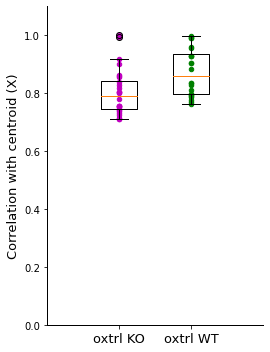

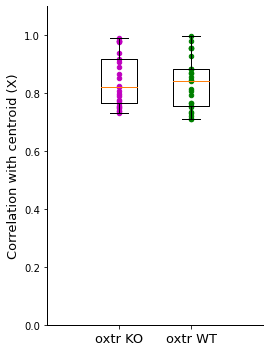

In [8]:
#### centroid correlation plot ####
n = 0
#
x = 2
if age_to_be_analysed == 56: 
    x = 3

for i in range (0, x):  
    mpl.rcParams['axes.linewidth'] = 1
    fig = plt.figure()
    fig.set_size_inches(4, 5)
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks(fontsize= 13)
    plt.xlim(0, 3)
    plt.ylim(0,1.1)
    plt.ylabel('Correlation with centroid (X)', fontsize = 13)
    plt.tight_layout()
    x_1 = []
    x_2 = []
    plt.boxplot([all_cen_corr[n][:, 0][:, 0], all_cen_corr[n+1][:, 0][:, 0]], labels = [names[n], names[n+1]], positions = [1,2], showmeans = False, widths = (0.5,0.5))
    for x in range (0, analysis_df[genotypes[n]].count()):
        x_1.append(1)
    for x in range (0, analysis_df[genotypes[n+1]].count()):
        x_2.append(2)
    
    # plot individual data points    
    for x, y in zip(x_1, all_cen_corr[n][:, 0][:, 0]):
        plt.scatter(x, y, c='m', alpha=1, s = 20, marker = "o")
        
    for x, y in zip(x_2, all_cen_corr[n+1][:, 0][:, 0]):
        plt.scatter(x, y, c='g', alpha=1, s = 20, marker = "o")
        
    t, p = stats.mannwhitneyu(all_cen_corr[n][:, 0][:, 0], all_cen_corr[n+1][:, 0][:, 0])
    print(names[n]  + ' - ' + names[n+1] + ' x: ', p)  
    n += 2
    # plt.savefig(saves[i] + '_centroidCorrelation.png', dpi = 300)

In [39]:
# find variance explained for every video 
get_variance = True
variance = []
for m in range (0, len(genotypes)): 
    v = []
    nVideos = analysis_df[genotypes[m]].count()
    for n in range (0, nVideos): 
        video = analysis_df.iloc[n, m]
        v.append (PCA_per_frame(video, get_variance))
    
    v = np.sum(v, axis = 1) # sum variance explained of both pcs 
    variance.append(v)

### sort variance by genotype
ILR1K_var = variance[0]
ILR1w_var = variance[1]
ILR2K_var = variance[2]
ILR2w_var = variance[3]


C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


oxtrl KO - oxtrl WT 0.0801294015646164
oxtr KO - oxtr WT 0.4438098723653957


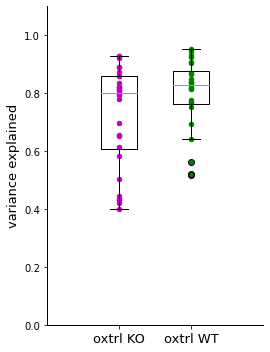

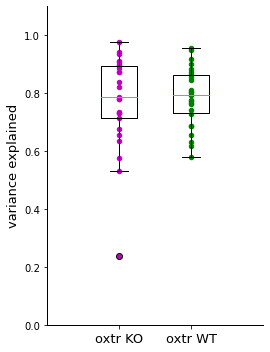

In [10]:
#### variance exlained plot ####
n = 0
for i in range (0, 2): 
    mpl.rcParams['axes.linewidth'] = 1
    fig = plt.figure()
    fig.set_size_inches(4, 5)
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks(fontsize= 13)
    plt.xlim(0, 3)
    plt.ylim(0,1.1)
    plt.ylabel('variance explained', fontsize = 13)
    plt.tight_layout()
    x_1 = []
    x_2 = []
    plt.boxplot([variance[n], variance[n+1]], labels = [names[n], names[n+1]], positions = [1,2], showmeans = False, widths = (0.5,0.5))
    for x in range (0, analysis_df[genotypes[n]].count()):
        x_1.append(1)
    for x in range (0, analysis_df[genotypes[n+1]].count()):
        x_2.append(2)
    
    # plot individual data points    
    for x, y in zip(x_1, variance[n]):
        plt.scatter(x, y, c='m', alpha=1, s = 20, marker = "o")

    for x, y in zip(x_2, variance[n+1]):
        plt.scatter(x, y, c='g', alpha=1, s = 20, marker = "o")

    t, p = stats.mannwhitneyu(variance[n], variance[n+1])
    print(names[n]  + ' - ' + names[n+1] , p) 
    n += 2
    #plt.savefig(saves[i] + '_varianceExplained.png', dpi = 300)

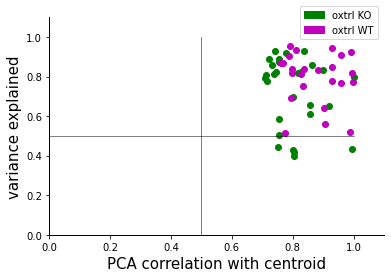

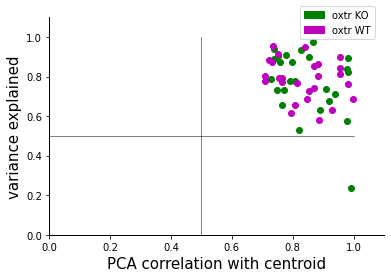

In [11]:
#### variance vs centroid correlation plot ####
n = 0 
for i in range (0, 2):
    fig = plt.figure()
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylim(0, 1.1)
    plt.xlim(0, 1.1)
    py = [0.5, 0.5]
    px = [0,1]
    plt.plot(px, py, c='black', linewidth=0.5)
    py = [0, 1]
    px = [0.5, 0.5]
    plt.plot(px, py, c='black', linewidth=0.5)
    temp = np.concatenate(all_cen_corr[n][:])
    scatter1 = plt.scatter(np.absolute(temp.flat[::2]), variance[n], c = 'g')
    green_patch = mpatches.Patch(color='g', label=names[n])
    n += 1
    temp = np.concatenate(all_cen_corr[n][:])
    scatter2 = plt.scatter(np.absolute(temp.flat[::2]), variance[n], c = 'm')
    magenta_patch = mpatches.Patch(color='m', label=names[n])
    n +=1
    plt.ylabel('variance explained', fontsize = 15)
    plt.xlabel('PCA correlation with centroid', fontsize = 15)
    plt.legend(handles=[green_patch, magenta_patch], bbox_to_anchor=(0.75, 1.05), loc='upper left', borderaxespad=0.)
    plt.savefig(saves[i]+'_varianceExplained_v_group_cen.png', dpi = 300)
    plt.show()
    # print(str(genotypes[i]),  pearsonr(np.absolute(all_cen_corr[i][0]), variance[i]))


In [12]:
# get the correlation between individual trajectories and the centroid of the group. Output will be 20 correlations - 
# one for each fish 
#required to run
def individualVScentroid(video, centroids):
    correlations = []
    x_col = []
    y_col = []
    for i in range (0, 20):
        x_col.append('x' + str(i+1))
        y_col.append('y' + str(i+1))
    
    
    if  isinstance(video, pd.DataFrame):
        for i in range(0, 20):
            correlation = np.array([pearsonr(centroids[:, 0], np.array(video[x_col[i]])), pearsonr(centroids[:, 1], np.array(video[y_col[i]]))])
            correlations.append(correlation)
    else:
        print('s')
        for i in range(0, 20):
            correlation = np.array([pearsonr(centroids[:, 0], video[:, i*2]), pearsonr(centroids[:, 1], video[:, i*2 + 1])])
            correlations.append(correlation)
          
    return(correlations)  

In [13]:
x_C_correlations =[]
y_C_correlations =[]
for m in range (0, len(genotypes)): 
    x_C_correlation =[]
    y_C_correlation =[]
    nVideos = analysis_df[genotypes[m]].count()
    for n in range (0, nVideos): 
        video = analysis_df.iloc[n, m]
        centroid = np.concatenate(get_centroid(video), 0)
        correlations = np.concatenate(individualVScentroid(video, centroid),0)
        correlations = correlations[:, 0]
        x_C_correlation.append(np.mean(correlations[0::2]))
        y_C_correlation.append(np.mean(correlations[1::2]))
        
    x_C_correlations.append(x_C_correlation)
    y_C_correlations.append(y_C_correlation)

C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\anneserl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


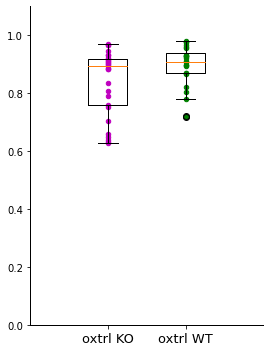

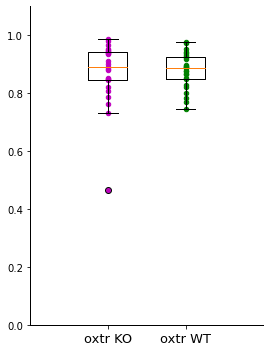

In [14]:
#### individual trajcetory correlation to centroid 
n = 0 
for i in range (0, 2):
    fig = plt.figure()
    ax = plt.axes()
    fig.set_size_inches(4, 5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks(fontsize= 13)
    #plt.yticks(fontsize= 7)
    plt.xlim(0, 3)
    plt.ylim(0,1.1)
    #plt.ylabel('variance explained', fontsize = 13)
    plt.tight_layout()
    x_1 = []
    x_2 = []
    plt.boxplot([x_C_correlations[n], x_C_correlations[n+1]], labels = [names[n], names[n+1]] ,positions = [1,2], showmeans = False, widths = (0.5,0.5))
    for x in range (0, analysis_df[genotypes[n]].count()):
        x_1.append(1)
    for x in range (0, analysis_df[genotypes[n+1]].count()):
        x_2.append(2)
    n += 2
    #plt.savefig(saves[i]+'_individual_correlation.png', dpi = 300)

oxtrl KO (0.9884158836579173, 7.486795217680263e-18)
oxtrl WT (0.9852267307432445, 1.4062670740962017e-17)
oxtr KO (0.9938851201792601, 1.1942546245247886e-19)
oxtr WT (0.9861386562438718, 7.231819177866485e-18)
pth2 KO (0.9917305022221422, 3.2689236171489166e-20)
pth2 WT (0.9885819948656127, 3.058557878467466e-21)


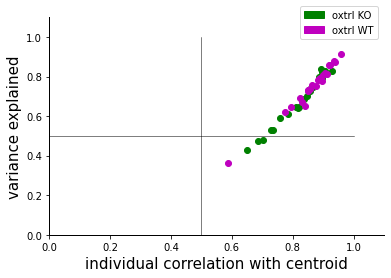

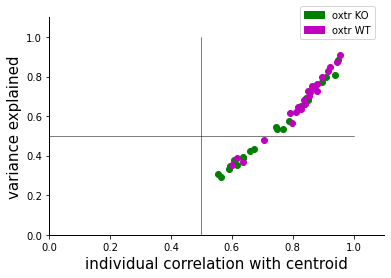

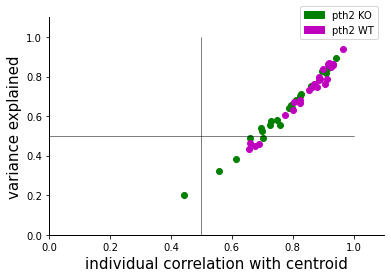

In [14]:
#### variance vs individual projectories centroid correlation plot ####

n = 0 
for i in range (0, x):
    fig = plt.figure()
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylim(0, 1.1)
    plt.xlim(0, 1.1)
    py = [0.5, 0.5]
    px = [0,1]
    plt.plot(px, py, c='black', linewidth=0.5)
    py = [0, 1]
    px = [0.5, 0.5]
    plt.plot(px, py, c='black', linewidth=0.5)
    scatter1 = plt.scatter(np.absolute(x_C_correlations[n]), variance[n], c = 'g')
    print(str(names[n]),  pearsonr(np.absolute(x_C_correlations[n]), variance[n]))
    green_patch = mpatches.Patch(color='g', label=names[n])
    n += 1
    scatter2 = plt.scatter(np.absolute(x_C_correlations[n]), variance[n], c = 'm')
    print(str(names[n]),  pearsonr(np.absolute(x_C_correlations[n]), variance[n]))
    magenta_patch = mpatches.Patch(color='m', label=names[n])
    n +=1
    plt.ylabel('variance explained', fontsize = 15)
    plt.xlabel('individual correlation with centroid', fontsize = 15)
    plt.legend(handles=[green_patch, magenta_patch], bbox_to_anchor=(0.75, 1.05), loc='upper left', borderaxespad=0.)

    plt.savefig(saves[i]+'_varianceExplained_v_indv_cen.png', dpi = 300)
    # plt.title(str(genotypes[i]))
    plt.show
    #print(str(genotypes[i]),  pearsonr(np.absolute(all_cen_corr[i][0]), variance[i]))

In [15]:
# synthetic videos/trajectories 

#### random fish ####

# put all videos together 
all_videos = []
all_videos_df = []
for m in range (0, len(genotypes)): 
    nVideos = analysis_df[genotypes[m]].count()
    for n in range (0, nVideos): 
        video = analysis_df.iloc[n, m]
        all_videos.append(np.array(video))
        all_videos_df.append(video)
        


In [16]:
# create 25 random videos. Each new video has 20 different fish from 20 different videos

random_videos = []
animal_list = []
for i in range (0, 20):
    animal_list.append('x' + str(i+1))
    animal_list.append('y' + str(i+1))

for k in range (0, 25): 
    random_video = random.sample(range(0, len(all_videos)), 20)
    random_fish = random.sample(range(1, 21), 20)
    df_random = pd.DataFrame(index = range(0, 54000), columns = animal_list)

    for j in range (0, 20):
        x = all_videos_df[random_video[j]]['x'+ str(random_fish[j])]
        y = all_videos_df[random_video[j]]['y'+ str(random_fish[j])]

        df_random.at[:,'x' + str(j+ 1)] = x
        df_random.at[:,'y' + str(j +1)] = y
        
    random_videos.append(df_random)


In [17]:
###analysis random videos####
get_variance = False
get_variance_1 = True 

xcorrelation_random = []
ycorrelation_random = []
variance_random = []
x_C_correlation_random =[]
y_C_correlation_random =[]

for n in range (0, 25): 
    video = random_videos[n]
    temp = correlation_centroid_pca(video)
    xcorrelation_random.append(temp[0])
    ycorrelation_random.append(temp[1])
    variance_random.append(PCA_per_frame(video, get_variance_1))
    correlations_random = np.concatenate(individualVScentroid(video, centroid),0)
    x_C_correlation_random.append(np.mean(correlations_random[0::2]))
    y_C_correlation_random.append(np.mean(correlations_random[1::2]))

xcorrelation_random = np.absolute(xcorrelation_random)
ycorrelation_random = np.absolute(ycorrelation_random)



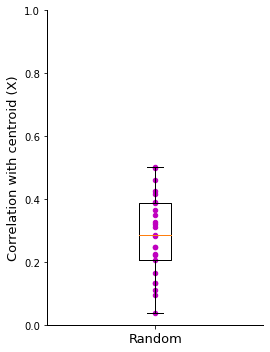

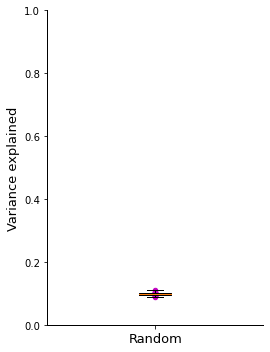

In [18]:
### random video plot 
fig = plt.figure()
fig.set_size_inches(4, 5)
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize= 13)
plt.ylim(0,1)
plt.ylabel('Correlation with centroid (X)', fontsize = 13)
plt.tight_layout()
x_1 = []
plt.boxplot(xcorrelation_random[:, 0][:, 0], labels = ['Random'],  showmeans = False)
for x in range (0, 25):
    x_1.append(1)

# plot individual data points    
for x, MT02KO in zip(x_1, xcorrelation_random[:, 0][:, 0]):
     plt.scatter(x, MT02KO, c='m', alpha=1, s = 20, marker = "o")
        
# plt.savefig('random_centroid_correlation.png', dpi = 300)

fig = plt.figure()
fig.set_size_inches(4, 5)
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
variance_sum = np.sum(variance_random, 1)
plt.xticks(fontsize= 13)
plt.ylim(0,1)
plt.ylabel('Variance explained', fontsize = 13)
plt.tight_layout()
x_1 = []
plt.boxplot(variance_sum, labels = ['Random'],  showmeans = False)
for x in range (0, 25):
    x_1.append(1)

# plot individual data points    
for x, MT02KO in zip(x_1, variance_sum):
     plt.scatter(x, MT02KO, c='m', alpha=1, s = 20, marker = "o")
# plt.savefig('random_variance_explained.png', dpi = 300)

In [19]:
### create 20 videos where fish from the same videos are gradually introduced 
random_videos_grad_inc = []

animal_list = []
for i in range (0, 20):
    animal_list.append('x' + str(i+1))
    animal_list.append('y' + str(i+1))
    
for h in range(0, 20): 
    random_videos1 = []
    for k in range (0, 10): 
        random_video = random.sample(range(1, len(all_videos_df)), 20 - h)        
        for g in range(0, h):
            random_video.append(1) # change this to the video number you gradually want to increase
        random_fish = random.sample(range(1, 21), 20)
        df_random = pd.DataFrame(index = range(0, 54000), columns = animal_list)

        for j in range (0, 20):

            x = all_videos_df[random_video[j]]['x'+ str(random_fish[j])]
            y = all_videos_df[random_video[j]]['y'+ str(random_fish[j])]

            df_random.at[:,'x' + str(j+ 1)] = x
            df_random.at[:,'y' + str(j +1)] = y
        random_videos1.append(df_random)
        
    random_videos_grad_inc.append(random_videos1)

In [76]:
###analysis random videos gradual increase in fish from same video ####
get_variance = False
get_variance_1 = True 
x_correlation_random_grad = []
y_correlation_random_grad = []
variance_random_grad = []
for i in range (0, 20):
    xcorrelation_random_grad = []
    ycorrelation_random_grad = []
    variance1 = []
    x_C_correlation_random_grad =[]
    y_C_correlation_random_grad =[]

    for n in range (0, 10): 
        video = random_videos_grad_inc[i][n] 
        temp = correlation_centroid_pca(video)
        xcorrelation_random_grad.append(np.absolute(temp[0]))
        ycorrelation_random_grad.append(np.absolute(temp[1]))
        v1 = PCA_per_frame(video, get_variance_1)
        v1= np.sum(v1)
        variance1.append(v1)
    xcorrelation_random_grad = np.absolute(np.concatenate(xcorrelation_random_grad))
    ycorrelation_random_grad = np.absolute(np.concatenate(ycorrelation_random_grad))
    x_correlation_random_grad.append(np.mean(xcorrelation_random_grad[0][0]))
    y_correlation_random_grad.append(np.mean(ycorrelation_random_grad[0][0]))
    variance_random_grad.append(variance1)

In [77]:
xcorrelation_original = []
ycorrelation_original = []
get_variance = True 
get_variance1 = False
video = analysis_df.iloc[1, 0] # change to the correct video 
variance_original = PCA_per_frame(video , get_variance)

temp = correlation_centroid_pca(video)
xcorrelation_original.append(temp[0])
ycorrelation_original.append(temp[1])

ValueError: x and y must be the same size

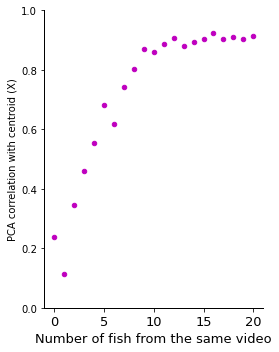

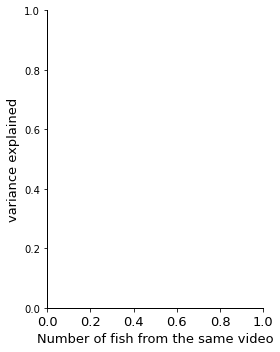

In [78]:
fig = plt.figure()
fig.set_size_inches(4, 5)
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize= 13)
plt.ylim(0,1)
plt.xlabel('Number of fish from the same video', fontsize = 13)
plt.ylabel('PCA correlation with centroid (X)')
plt.tight_layout()
x_1 = []

for x in range (0, 20):
    x_1.append(x)

# plot individual data points    
for x, MT02KO in zip(x_1, x_correlation_random_grad):
     plt.scatter(x, MT02KO, c='m', alpha=1, s = 20, marker = "o")

plt.scatter(20,np.sum(xcorrelation_original), c='m', alpha=1, s = 20, marker = "o") # original video 
        
# plt.savefig('PCA_correlation_explained_lessR.png', dpi = 300)

fig = plt.figure()
fig.set_size_inches(4, 5)
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize= 13)
plt.ylim(0,1)
plt.xlabel('Number of fish from the same video', fontsize = 13)
plt.ylabel('variance explained', fontsize = 13)
plt.tight_layout()
x_1 = []

for x in range (0, 20):
    x_1.append(x)

# plot individual data points    
for x, MT02KO in zip(x_1, variance_random_grad):
     plt.scatter(x, MT02KO, c='m', alpha=1, s = 20, marker = "o")

plt.scatter(20,np.sum(variance_original), c='m', alpha=1, s = 20, marker = "o") # original video 
plt.show()